In [ ]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from itertools import groupby
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
hydrodf = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/hphob_dict_lig47")

In [ ]:
frames = [hydrodf[key]['distance'] for key in hydrodf.keys()]
hydrocombined = np.concatenate(frames, axis=1)
print(hydrocombined.shape)

(1100889, 1500)


In [ ]:
df = pd.read_pickle("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/lig47_hbonds_dict")

In [ ]:
# h bond cutoff of 0.35 nm Baker Hubbard

In [ ]:
frames = [df[key]['distances'] for key in df.keys()]
combined = np.concatenate(frames, axis=1)
print(combined.shape)

(1100889, 314)


In [ ]:
dfaro = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/aro_contacts.npy")
print(dfaro.shape)

(1100889, 3)


In [ ]:
dcharges = np.load("/Users/jackmcmahon/Development/CHEM 101.6/residence_time_prediction/charge_dist_matrix.npy")
print(dcharges.shape)

(1100889, 9)


In [ ]:
dmat = np.load("distance_matrix_full_LIG.npy")
print(dmat.shape)

def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

(1100889, 20)


In [ ]:
#binary
# 0.35 h bond, 0.5 charge, 0.4 hydrophobic, 1 aromatic
# print(np.any(dfaro >= 1))
# print(np.any(combined >= 0.35))
# print(np.any(dcharges >= 0.5))
# print(np.any(hydrocombined >= 0.4))

True
True
True
True


In [ ]:
# inputs = torch.from_numpy(std_avg)
# inputs = torch.tensor(inputs, dtype=torch.float32)
# print(inputs.shape)
# print(inputs)
# targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
# targets = torch.tensor(targets, dtype=torch.float32)
# print(targets.shape)
# print(targets)
# dataset = TensorDataset(inputs, targets)

# N = dmat.shape[0]
N = 11278
indices = np.arange(N)
# indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.8*N)]
test_indices = indices[int(0.8*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

In [ ]:
events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), 1])
avg_aro_all = np.zeros([len(events_all), 1])
avg_charges_all = np.zeros([len(events_all), 1])
avg_hydro_all = np.zeros([len(events_all), 1])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.any(combined[event[0]:event[-1]+1] <= 0.35)
  avg_aro_all[count] = np.any(dfaro[event[0]:event[-1]+1] >= 1)
  avg_charges_all[count] = np.any(dcharges[event[0]:event[-1]+1] <= 0.5)
  avg_hydro_all[count] = np.any(hydrocombined[event[0]:event[-1]+1] <= 0.4)
  count += 1
  
avg_new = np.concatenate([avg_all,avg_hydro_all,avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])


# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]


print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)


Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 24)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 24)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 24)


In [ ]:
mapping = mapping_5_476
avg = avg_5_476
scaledmapping = mapping/100
a1 = avg[train_indices]
m1 = scaledmapping[train_indices]
a2 = avg[val_indices]
m2 = scaledmapping[val_indices]
a3 = avg[test_indices]
m3 = scaledmapping[test_indices]
print("input shape for train", a1.shape)
a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

ap2 = preds*100
al2 = m3*100

print("pred mean", np.mean(ap2))
print("groun truth mean", np.mean(al2))

input shape for train (7894, 24)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.2025  | val_0_mse: 0.99663 |  0:00:00s
epoch 1  | loss: 0.50182 | val_0_mse: 0.62242 |  0:00:00s
epoch 2  | loss: 0.38152 | val_0_mse: 0.62774 |  0:00:01s
epoch 3  | loss: 0.35251 | val_0_mse: 0.64154 |  0:00:01s
epoch 4  | loss: 0.34361 | val_0_mse: 0.64011 |  0:00:01s
epoch 5  | loss: 0.32703 | val_0_mse: 0.62929 |  0:00:01s
epoch 6  | loss: 0.31852 | val_0_mse: 0.61823 |  0:00:02s
epoch 7  | loss: 0.32122 | val_0_mse: 0.60638 |  0:00:02s
epoch 8  | loss: 0.30782 | val_0_mse: 0.55578 |  0:00:02s
epoch 9  | loss: 0.30462 | val_0_mse: 0.51703 |  0:00:03s
epoch 10 | loss: 0.30826 | val_0_mse: 0.4999  |  0:00:03s
epoch 11 | loss: 0.30485 | val_0_mse: 0.50105 |  0:00:03s
epoch 12 | loss: 0.30291 | val_0_mse: 0.50886 |  0:00:04s
epoch 13 | loss: 0.28925 | val_0_mse: 0.48623 |  0:00:04s
epoch 14 | loss: 0.2906  | val_0_mse: 0.48888 |  0:00:04s
epoch 15 | loss: 0.29247 | val_0_mse: 0.50248 |  0:00:04s
epoch 16 | loss: 0.29121 | val_0_mse: 0.48816 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


pred mean 47.33249
groun truth mean 52.211436170212764


r2: 0.7934889309606692


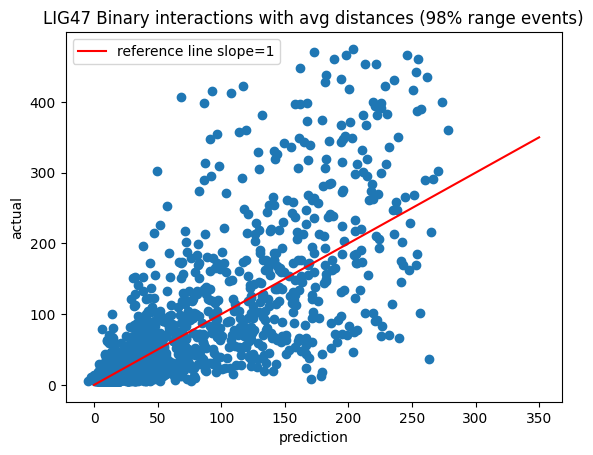

In [ ]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 350,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 Binary interactions with avg distances (98% range events)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()


In [ ]:
mapping = mapping_all
avg = avg_all
scaledmapping = mapping/100
a1 = avg[train_indices]
m1 = scaledmapping[train_indices]
a2 = avg[val_indices]
m2 = scaledmapping[val_indices]
a3 = avg[test_indices]
m3 = scaledmapping[test_indices]
print("input shape for train", a1.shape)
a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

ap2 = preds*100
al2 = m3*100

print("pred mean", np.mean(ap2))
print("groun truth mean", np.mean(al2))

input shape for train (7894, 20)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.45993 | val_0_mse: 1.07091 |  0:00:00s
epoch 1  | loss: 4.14826 | val_0_mse: 1.0706  |  0:00:00s
epoch 2  | loss: 1.94254 | val_0_mse: 1.11433 |  0:00:00s
epoch 3  | loss: 3.78801 | val_0_mse: 1.06348 |  0:00:01s
epoch 4  | loss: 3.77506 | val_0_mse: 1.07523 |  0:00:01s
epoch 5  | loss: 3.7877  | val_0_mse: 1.07322 |  0:00:01s
epoch 6  | loss: 3.77299 | val_0_mse: 1.05716 |  0:00:02s
epoch 7  | loss: 3.88863 | val_0_mse: 1.05058 |  0:00:02s
epoch 8  | loss: 3.64206 | val_0_mse: 1.05919 |  0:00:02s
epoch 9  | loss: 3.0807  | val_0_mse: 1.05001 |  0:00:03s
epoch 10 | loss: 3.45394 | val_0_mse: 1.04585 |  0:00:03s
epoch 11 | loss: 3.62892 | val_0_mse: 1.04139 |  0:00:03s
epoch 12 | loss: 1.70212 | val_0_mse: 1.02911 |  0:00:04s
epoch 13 | loss: 3.47809 | val_0_mse: 1.04498 |  0:00:04s
epoch 14 | loss: 3.46068 | val_0_mse: 1.04497 |  0:00:04s
epoch 15 | loss: 3.79093 | val_0_mse: 1.02786 |  0:00:04s
epoch 16 | loss: 3.4734  | val_0_mse: 1.03701 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


r2: 0.6688287756631495


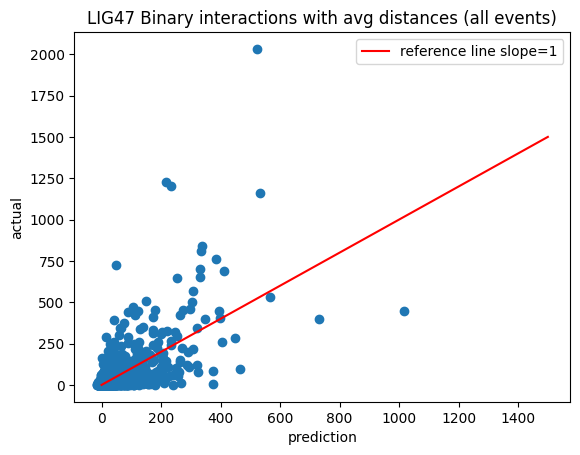

In [ ]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 1500,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 Binary interactions with avg distances (all events)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

In [ ]:
top = (-al2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
top = (-ap2).argsort(axis=0)[:10]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])
  
print("")
  
bottom = (ap2).argsort(axis=0)[:10]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted 520.7912 real: 2032.0
predicted 216.28754 real: 1230.0
predicted 233.95497 real: 1205.0
predicted 531.29236 real: 1158.0
predicted 337.57358 real: 841.0
predicted 334.06528 real: 808.0
predicted 386.11093 real: 764.0
predicted 48.457996 real: 728.0
predicted 332.27145 real: 704.0
predicted 409.98935 real: 689.0

predicted 1015.1562 real: 447.0
predicted 730.6284 real: 396.0
predicted 565.6894 real: 530.0
predicted 531.29236 real: 1158.0
predicted 520.7912 real: 2032.0
predicted 464.85663 real: 98.0
predicted 448.98926 real: 283.0
predicted 409.98935 real: 689.0
predicted 405.07397 real: 261.0
predicted 396.85175 real: 401.99999999999994

predicted -15.477602 real: 1.0
predicted -14.767994 real: 2.0
predicted -13.771072 real: 4.0
predicted -13.542599 real: 1.0
predicted -12.953258 real: 1.0
predicted -12.9303875 real: 2.0
predicted -12.881994 real: 1.0
predicted -12.686571 real: 2.0
predicted -12.602679 real: 2.0
predicted -12.562113 real: 16.0


In [ ]:
events_all = combined_residence_events(dmat)
mapping_all = np.zeros(len(events_all))
avg_all = np.zeros([len(events_all), len(dmat[0,:])])
mapping_5_476 = np.zeros(len(events_all))
avg_5_476 = np.zeros([len(events_all), len(dmat[0,:])])
mapping_25_476 = np.zeros(len(events_all))
avg_25_476 = np.zeros([len(events_all), len(dmat[0,:])])


avg_hbond_all = np.zeros([len(events_all), 1])
avg_aro_all = np.zeros([len(events_all), 1])
avg_charges_all = np.zeros([len(events_all), 1])
avg_hydro_all = np.zeros([len(events_all), 1])

# avg_all is all events
# avg_5_476 is middle range
# avg_25_476 is narrowest range

count = 0
for event in events_all:
  mapping_all[count] = len(event)
  avg_all[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  avg_hbond_all[count] = np.any(combined[event[0]:event[-1]+1] <= 0.35)
  avg_aro_all[count] = np.any(dfaro[event[0]:event[-1]+1] >= 1)
  avg_charges_all[count] = np.any(dcharges[event[0]:event[-1]+1] <= 0.5)
  avg_hydro_all[count] = np.any(hydrocombined[event[0]:event[-1]+1] <= 0.4)
  count += 1
  
avg_new = np.concatenate([avg_hydro_all,avg_hbond_all, avg_aro_all, avg_charges_all], axis=1)

# stats
sortevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
print("Longest five events:", sortevents[:5])


# Getting different ranges
mapping_5_476 = mapping_all[mapping_all > 4]
avg_5_476 = avg_new[mapping_all > 4]
avg_5_476 = avg_5_476[mapping_5_476 < 477]
mapping_5_476 = mapping_5_476[mapping_5_476 < 477]

mapping_25_476 = mapping_all[mapping_all > 24]
avg_25_476 = avg_new[mapping_all > 24]
avg_25_476 = avg_25_476[mapping_25_476 < 477]
mapping_25_476 = mapping_25_476[mapping_25_476 < 477]


print("Total events:", len(mapping_all))
print("With avg distance input data of shape:", avg_new.shape)

print("Events between 5 and 476 frames:", len(mapping_5_476))
print("With avg distance in put data of shape:", avg_5_476.shape)

print("Events between 25 and 476 frames:", len(mapping_25_476))
print("With avg distance input data of shape:", avg_25_476.shape)

Longest five events: [12021  7432  5990  4327  3629]
Total events: 32264
With avg distance input data of shape: (32264, 4)
Events between 5 and 476 frames: 11279
With avg distance in put data of shape: (11279, 4)
Events between 25 and 476 frames: 4589
With avg distance input data of shape: (4589, 4)


In [ ]:
mapping = mapping_5_476
avg = avg_5_476
scaledmapping = mapping/100
a1 = avg[train_indices]
m1 = scaledmapping[train_indices]
a2 = avg[val_indices]
m2 = scaledmapping[val_indices]
a3 = avg[test_indices]
m3 = scaledmapping[test_indices]
print("input shape for train", a1.shape)
a1 = a1.reshape(a1.shape[0], -1)
a2 = a2.reshape(a2.shape[0], -1)
a3 = a3.reshape(a3.shape[0], -1)

clf = TabNetRegressor()
clf.fit(
  a1, m1.reshape(-1, 1),
  eval_set=[(a2, m2.reshape(-1, 1))], max_epochs=100
)

preds = clf.predict(a3)
preds = preds[:,0]

ap2 = preds*100
al2 = m3*100

print("pred mean", np.mean(ap2))
print("groun truth mean", np.mean(al2))

input shape for train (7894, 4)


/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68054 | val_0_mse: 0.8048  |  0:00:00s
epoch 1  | loss: 0.41643 | val_0_mse: 0.70403 |  0:00:00s
epoch 2  | loss: 0.389   | val_0_mse: 0.94916 |  0:00:00s
epoch 3  | loss: 0.37841 | val_0_mse: 0.93512 |  0:00:01s
epoch 4  | loss: 0.37013 | val_0_mse: 0.72161 |  0:00:01s
epoch 5  | loss: 0.3822  | val_0_mse: 0.74557 |  0:00:01s
epoch 6  | loss: 0.375   | val_0_mse: 0.63773 |  0:00:02s
epoch 7  | loss: 0.37601 | val_0_mse: 0.55028 |  0:00:02s
epoch 8  | loss: 0.37321 | val_0_mse: 0.49105 |  0:00:02s
epoch 9  | loss: 0.37156 | val_0_mse: 0.45278 |  0:00:02s
epoch 10 | loss: 0.37702 | val_0_mse: 0.43771 |  0:00:03s
epoch 11 | loss: 0.37612 | val_0_mse: 0.4145  |  0:00:03s
epoch 12 | loss: 0.36756 | val_0_mse: 0.41579 |  0:00:03s
epoch 13 | loss: 0.37111 | val_0_mse: 0.41439 |  0:00:04s
epoch 14 | loss: 0.38013 | val_0_mse: 0.41501 |  0:00:04s
epoch 15 | loss: 0.3766  | val_0_mse: 0.41683 |  0:00:04s
epoch 16 | loss: 0.37647 | val_0_mse: 0.41052 |  0:00:05s
epoch 17 | los

/opt/anaconda3/envs/chemresearch/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


r2: 0.675529747142556


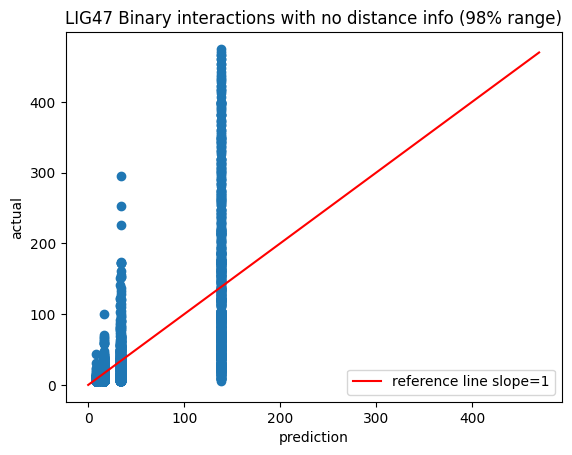

: 

In [ ]:
plt.scatter(ap2,al2)
# r=np.corrcoef(ap2[:,0], al2[:,0])
r=np.corrcoef(ap2, al2)
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(0, 470,20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("LIG47 Binary interactions with no distance info (98% range)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

In [ ]:
print(a1.mean(axis=0))
# 97% have hydro
# 87% have h bond
# 36% have aromatic
# 47% have charge interactions

[0.96744363 0.87433494 0.36128705 0.47504434]
